# Part 2. Function

#### By Oleksandr Gorpynich

#### Methodology
We use the k-means clustering algorithm to cluster the data points. To pick the # of clusters, we use a loop from 2 to 10 clusters and calculate the silhouette score for each iteration. We then pick the k that gives the highest silhouette score.

#### Metric to retrieve highly-variable genes
We calculate the standard deviation value for each gene and sort them in descending order. We then pick the top 230 genes with the highest standard deviation values. 

This is a good metric because it allows us to identify genes that have a high variance in expression levels across the samples - this is literally the definition of "standard deviation". However, the pitfall of using this is that we might miss out on genes that have a low variance but are still important in the diauxic shift process.

Let's begin by reading in the data and converting it to a pandas dataframe.

In [3]:
import pandas as pd

columns = [
    "Index",     
    "NamePartOne",      
    "NamePartTwo", 
    "R1.Ratio", 
    "R2.Ratio", 
    "R3.Ratio", 
    "R4.Ratio", 
    "R5.Ratio", 
    "R6.Ratio", 
    "R7.Ratio"
]

df = pd.read_csv(
    "data/diauxic_raw_ratios.txt",
    sep='\t', 
    header=0, 
    names=columns
)

df.head()

,Index,NamePartOne,NamePartTwo,R1.Ratio,R2.Ratio,R3.Ratio,R4.Ratio,R5.Ratio,R6.Ratio,R7.Ratio
0,1,YHR007C,ERG11,1.123596,1.190476,1.315789,0.877193,0.840336,0.383142,0.434783
1,2,YAL065C,NaN,0.909091,0.653595,1.136364,0.970874,0.781250,1.123596,1.234568
2,3,YAR062W,NaN,0.751880,1.149425,1.098901,0.925926,0.628931,1.176471,1.351351
3,4,YDR006C,SOK1,1.111111,0.833333,0.458716,0.334448,0.348432,0.671141,0.546448
4,5,YDR007W,TRP1,1.041667,1.020408,1.052632,0.787402,0.980392,1.063830,0.952381


Let's normalize the data by first dividing it by the mean, and then using log2 transform. 

In [7]:
# Normalize the data
import numpy as np
ratio_cols = [
    "R1.Ratio", "R2.Ratio", "R3.Ratio", 
    "R4.Ratio", "R5.Ratio", "R6.Ratio", "R7.Ratio"
]
# 1) Calculate the mean expression per gene (row)
df["mean_expr"] = df[ratio_cols].mean(axis=1)
# 2) Divide each ratio value by the per-gene mean
for col in ratio_cols:
    df[col] = df[col] / df["mean_expr"]
# 3) Drop the mean expression column
df.drop(columns=["mean_expr"], inplace=True)
# 4) Log2 transform the ratios
df[ratio_cols] = np.log2(df[ratio_cols])
df.head()


,Index,NamePartOne,NamePartTwo,R1.Ratio,R2.Ratio,R3.Ratio,R4.Ratio,R5.Ratio,R6.Ratio,R7.Ratio
0,1,YHR007C,ERG11,0.351303,0.434719,0.579109,-0.005853,-0.067781,-1.200869,-1.018453
1,2,YAL065C,NaN,-0.097663,-0.573691,0.224265,-0.002804,-0.316303,0.207963,0.343847
2,3,YAR062W,NaN,-0.428408,0.183931,0.119079,-0.128013,-0.686009,0.217483,0.417421
3,4,YDR006C,SOK1,0.853804,0.438767,-0.422527,-0.878344,-0.819250,0.126489,-0.170043
4,5,YDR007W,TRP1,0.079922,0.050174,0.095029,-0.323800,-0.007541,0.110295,-0.049361


Let's plot the data as a heatmap. Before we do this, we create a new "GeneID" collumn which is just the NamePartOne combined with NamePartTwo. 

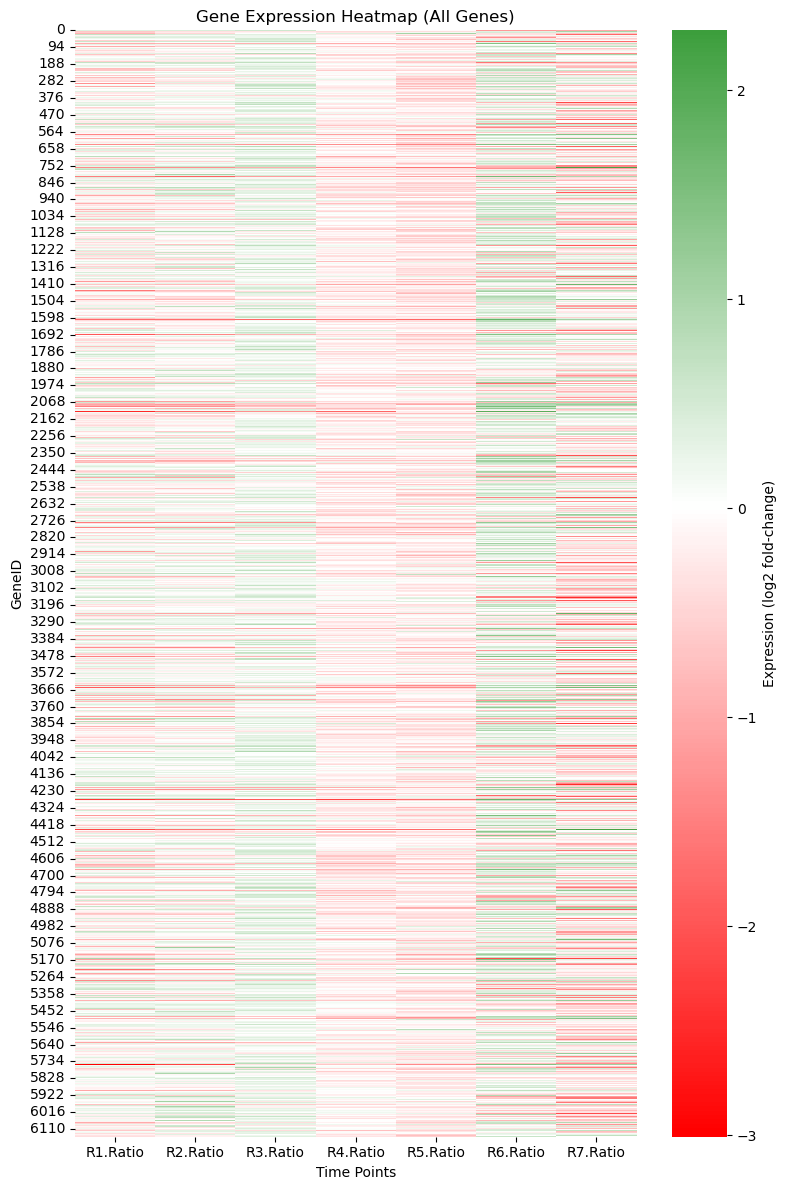

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def combine_names(row):
    if pd.isna(row["NamePartTwo"]) or row["NamePartTwo"] == "":
        return f"{row['NamePartOne']}"
    else:
        return f"{row['NamePartOne']}+{row['NamePartTwo']}"

df["GeneID"] = df.apply(combine_names, axis=1)

def plot_heatmap(df, title):
  plt.figure(figsize=(8, 12))  

  custom_cmap = mcolors.LinearSegmentedColormap.from_list(
      "", ["red", "white", "green"]
  )

  sns.heatmap(
      df[ratio_cols],    
      cmap=custom_cmap,        
      center=0,               
      cbar_kws={"label": "Expression (log2 fold-change)"}
  )

  plt.title(title)
  plt.xlabel("Time Points")
  plt.ylabel("GeneID")
  plt.tight_layout()
  plt.show()

plot_heatmap(df, "Gene Expression Heatmap (All Genes)")


As we can see, there are no detectable patterns in the data. This is expected as we have not yet clustered the data.

Let's now cluster the data using the k-means algorithm. We will use the silhouette score to determine the optimal number of clusters.

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df[ratio_cols].values

best_k = None
best_sil = -1
best_labels = None
for k in range(2, 11):
    kmeans_test = KMeans(n_clusters=k, random_state=17, n_init=10)
    labels_test = kmeans_test.fit_predict(X)
    sil = silhouette_score(X, labels_test)
    print(f"k={k}, silhouette={sil:.2f}")
    
    if sil > best_sil:
        best_sil = sil
        best_k = k
        best_labels = labels_test


print(f"Best k based on highest Silhouette Score: {best_k}, Score: {best_sil:.2f}")


k=2, silhouette=0.31
k=3, silhouette=0.32
k=4, silhouette=0.27
k=5, silhouette=0.21
k=6, silhouette=0.19
k=7, silhouette=0.18
k=8, silhouette=0.17
k=9, silhouette=0.16
k=10, silhouette=0.16
Best k based on highest Silhouette Score: 3, Score: 0.32


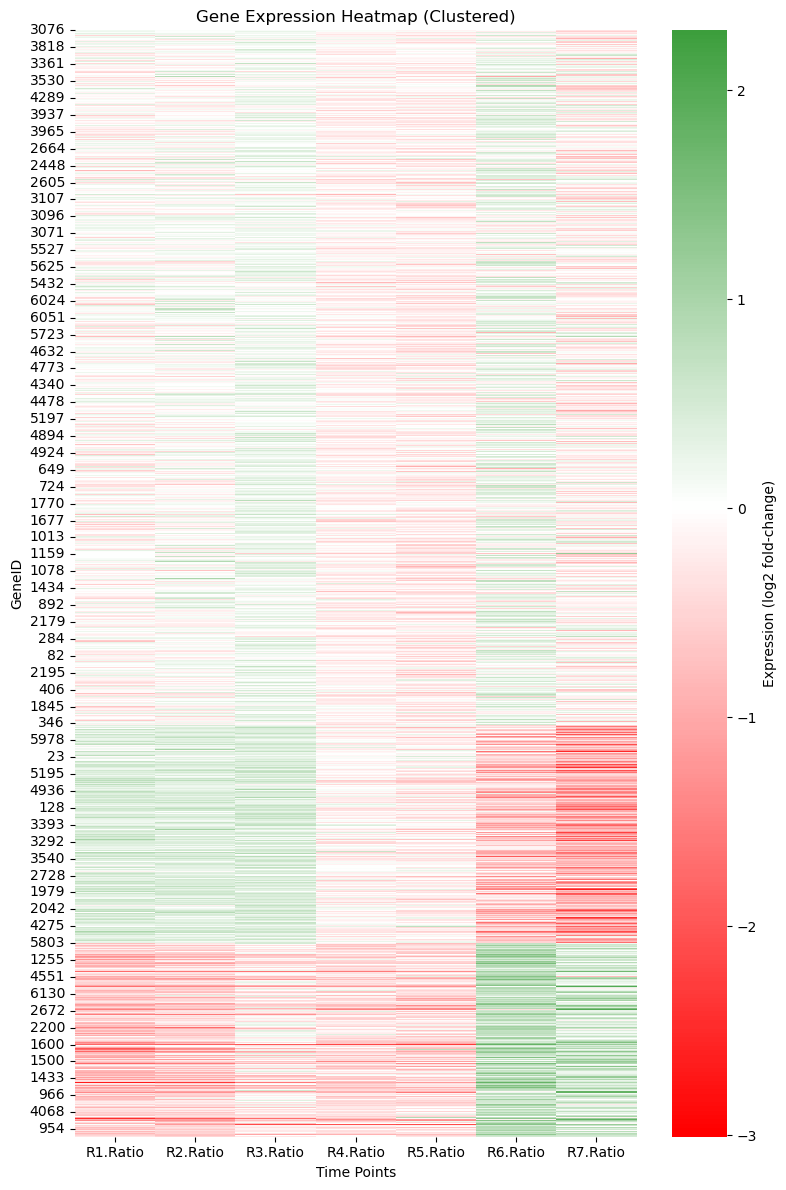

In [53]:
df["Cluster"] = best_labels
df_sorted = df.sort_values("Cluster")

plot_heatmap(df_sorted, "Gene Expression Heatmap (Clustered)")

While there are many genes at the beginning of the heat-map which are still highly variable (in terms of grouping), at the bottom we can see genes which pretty clearly changed expression patterns together. To be exact, I can make out two groups of genes, which distinctly change expression patterns at the R5 - R6 point. The first group very clearly lowers expression at R5, and the second group very clearly raises expression at R5.

Let's now pick the 230 genes with the highest standard deviation values and plot them as a heatmap.

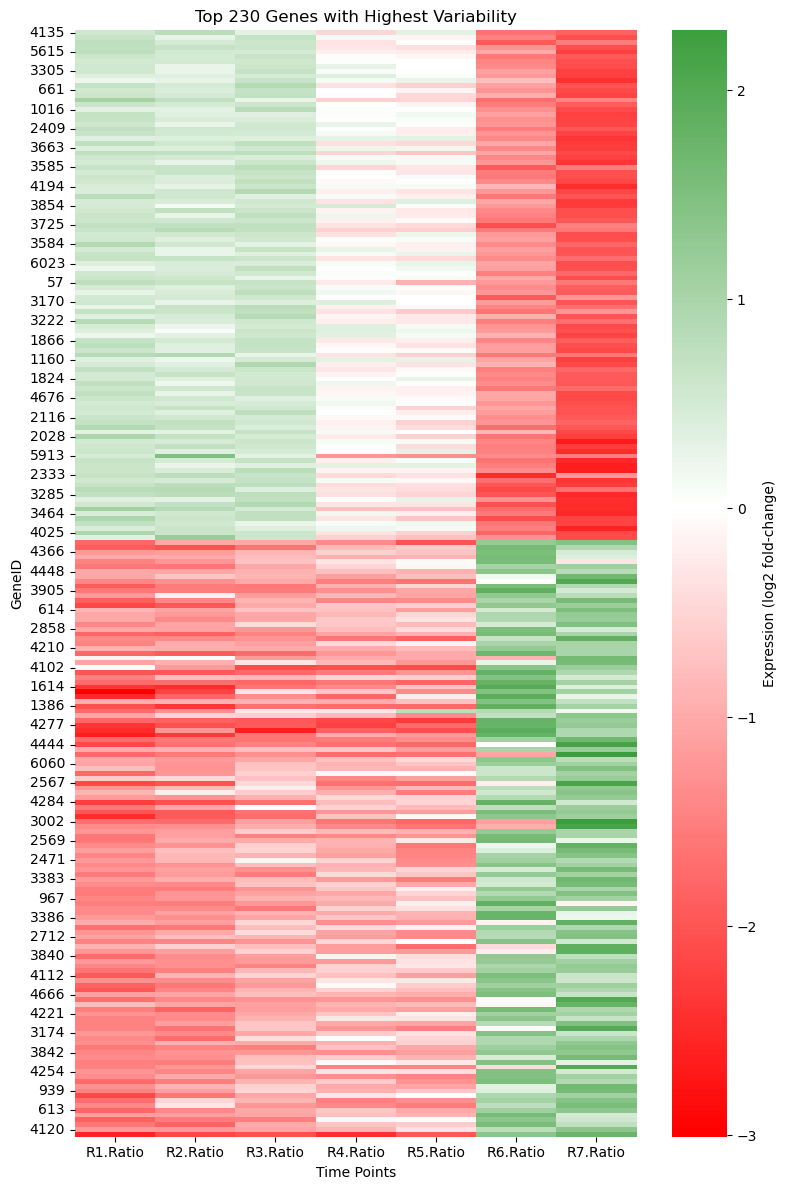

In [58]:
df["std_dev"] = df[ratio_cols].std(axis=1)
N = 230
df_filtered_topN = df.nlargest(N, "std_dev")
df_filtered_topN.drop(columns=["std_dev"], inplace=True)
df_filtered_topN = df_filtered_topN.sort_values("Cluster")
plot_heatmap(df_filtered_topN, f"Top {N} Genes with Highest Variability")

From the above, it is pretty clear that selecting the highly variable genes is a good way to identify genes that are changing expression patterns together. We can very clearly make out the two groups now, one of which lowers expression at R5 and the other raises expression at R5.

In [63]:
df_authors_230 = pd.read_csv(
    "data/230genes_log_expression.txt",
    sep='\t', 
    header=0, 
    names=columns
)

df_authors_230["GeneID"] = df_authors_230.apply(combine_names, axis=1)

# Let's create a set based on GeneID to computer the Jaccard Coefficient
set_topN = set(df_filtered_topN["GeneID"])
set_authors_230 = set(df_authors_230["GeneID"])

# Report the intersection of the two sets
intersection = set_topN.intersection(set_authors_230)
print(f"Intersection of the two sets: {len(intersection)}")

# Report the Jaccard Coefficient
jaccard = len(intersection) / len(set_topN.union(set_authors_230))
print(f"Jaccard Coefficient: {jaccard:.2f}")


Intersection of the two sets: 179
Jaccard Coefficient: 0.64


There are 179 genes that overlap betwen the 230 which we selected and the 230 author selected genes. The Jaccard Coefficient between the two sets is 0.64. 

In [69]:
# We didn't normalize the data as it seems to be already normalized
X_authors = df_authors_230[ratio_cols].values

best_k_author = None
best_sil_author = -1
best_labels_author = None
for k in range(2, 11):
    kmeans_test = KMeans(n_clusters=k, random_state=17, n_init=10)
    labels_test = kmeans_test.fit_predict(X_authors)
    sil = silhouette_score(X_authors, labels_test)
    print(f"k={k}, silhouette={sil:.2f}")
    
    if sil > best_sil_author:
        best_sil_author = sil
        best_k_author = k
        best_labels_author = labels_test


print(f"Best k based on highest Silhouette Score: {best_k_author}, Score: {best_sil_author:.2f}")

k=2, silhouette=0.75
k=3, silhouette=0.53
k=4, silhouette=0.50
k=5, silhouette=0.28
k=6, silhouette=0.29
k=7, silhouette=0.29
k=8, silhouette=0.26
k=9, silhouette=0.22
k=10, silhouette=0.23
Best k based on highest Silhouette Score: 2, Score: 0.75


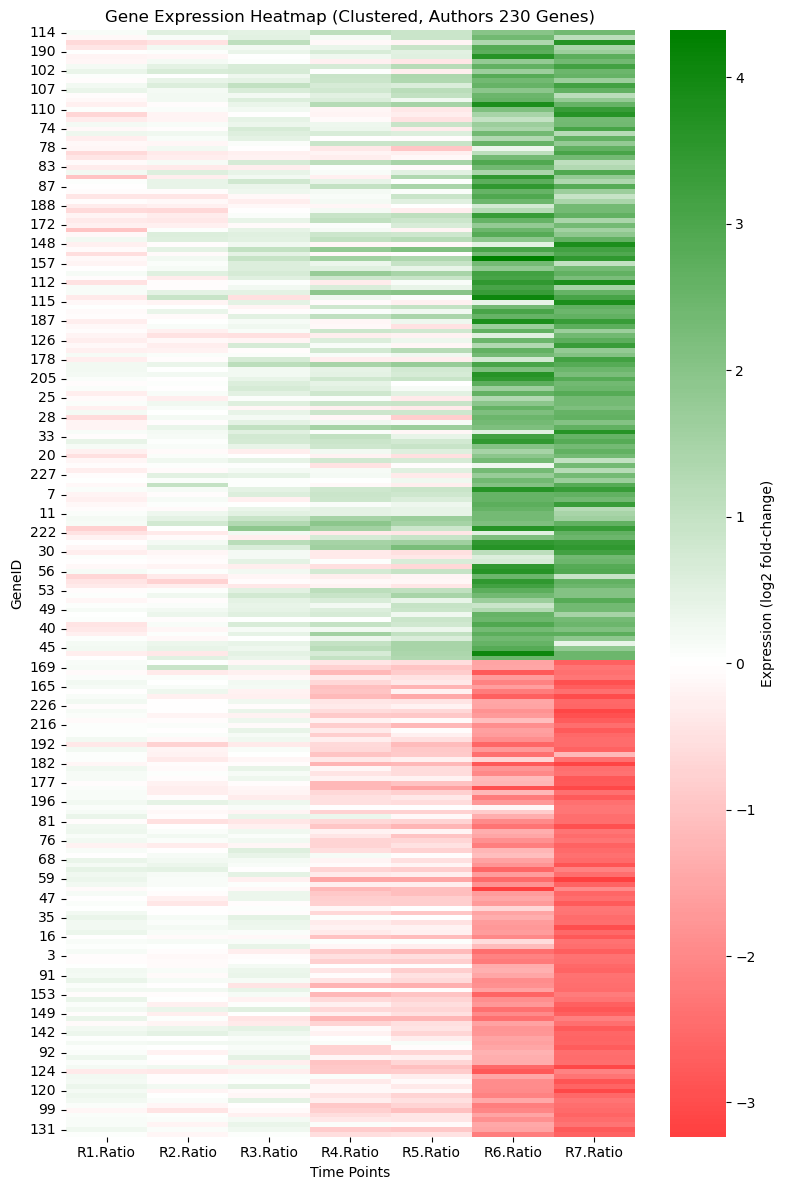

In [70]:
df_authors_230["Cluster"] = best_labels_author
df_authors_230_sorted = df_authors_230.sort_values("Cluster")

plot_heatmap(df_authors_230_sorted, "Gene Expression Heatmap (Clustered, Authors 230 Genes)")

From the above, it is very clear which groups of genes active at different stages. The first half of the genes are slightly active in the R1, R2, R3, R4, and R5 stages, but become really active in the R6 and R7 stage. Conversely, the second half of the genes are also slightly active in the R1, R2, R3 stages, but become slightly inactive in the R4 and R5 stages. They then really become inactive in the R6 and R7 stages.